# Code Demo For RUSLE Project

RUSLE stands for 'Revised Universal Soil Loss Equation'. This model is designed to estimate the long-term average annual rate of soil erosion caused by rainfall and associated surface runoff. It is expressed as: A = R × K × LS × C × P, where A represents the estimated average annual soil loss per unit area, R is the rainfall-runoff erosivity factor, K is the soil erodibility factor, LS combines slope length and steepness, C is the cover-management factor, and P is the support practice factor. 

## So why a coding project?

I saw a lot of studies which do this for a given study area, what I wanted to accomplish was to be able to automate this process for the 'lower 48', or the contiguous United States.

In [1]:
# Necessary Imports
import os
import openeo
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.io import MemoryFile
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
from shapely.geometry import box
import numpy as np

# Project Description to Date

Sadly, I only have two of the necessary factors written out - R factor and C factor.

The R Factor, the rainfall erosivity factor,

The calculation follows two different empirical equations based on the amount of precipitation:
    
- If P < 850 mm:
        R = 0.0483 * P^1.161

- If P ≥ 850 mm:
        R = 587.8 - 1.219 * P + 0.004105 * P^2


The data source I use is through PRISM, a project of Oregon State University.
https://prism.nacse.org/


The C Factor, the cover factor, is an inverse value of NDVI essentially - see See 
Van der Knijff, J.M., Jones, R.J.A. and Montanarella, L. (2000) 
Soil Erosion Risk Assessment in Europe. 
EUR 19044 EN, Office for Official Publications of the European Communities, Luxembourg, 34.
for more. 

The idea being that, an inverted value of NDVI - where high NDVI is a low cover factor value, will reduce the predicted erosion rate. 
I was using a source called openEO to calculate my cover factors, but this might be a bit impractical 

The end result should be a map with predicted soil loss in "Tons per hectare per year (t/ha/year)". 


Sadly, I have only done C factor and R factor. The C-Factor script also freshly broke today, giving me nonsense values for the US setting. 


So, my apologies, but today I will just demo the R factor for us all.


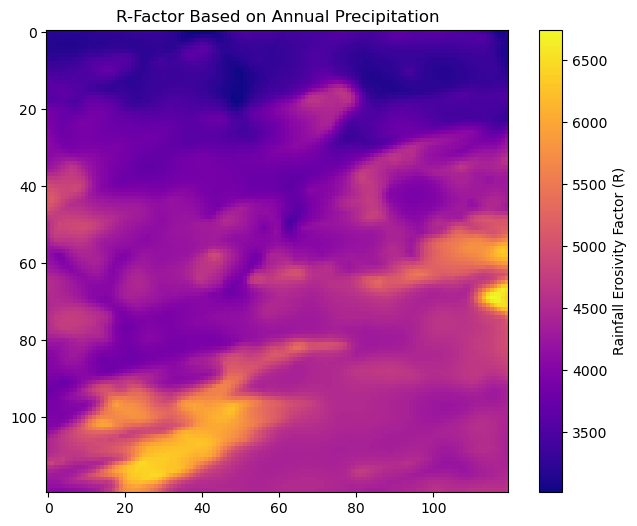

In [2]:
# Define the file path
raster_path = r"C:\Users\jpkeb\Documents\soil_erosion\tutorial_data\PRISM_ppt_30yr_normal_800mM4_annual_bil\PRISM_ppt_30yr_normal_800mM4_annual_bil.bil"

def clip_raster_within_conus(filepath, minx, miny, maxx, maxy):
    """
    Loads and clips a raster using a user-defined lat/lon bounding box,
    but only if it's within the contiguous U.S.
    
    Parameters:
        filepath (str): Path to the raster file
        minx, miny, maxx, maxy (float): Bounding box in EPSG:4326 (lon/lat)
    
    Returns:
        Tuple: (clipped_data, transform, metadata) or None if bbox is invalid
    """
    # Rough lat/lon bounding box for the contiguous U.S.
    conus_bounds = (-125, 24, -66.5, 49)

    # Check if the bbox falls within CONUS bounds
    if not (
        conus_bounds[0] <= minx <= conus_bounds[2] and
        conus_bounds[0] <= maxx <= conus_bounds[2] and
        conus_bounds[1] <= miny <= conus_bounds[3] and
        conus_bounds[1] <= maxy <= conus_bounds[3]
    ):
        print("❌ Bounding box is outside the contiguous U.S.")
        return None

    with rasterio.open(filepath) as src:
        raster_crs = src.crs
        # Convert bounding box from EPSG:4326 to raster CRS
        transformed_bounds = transform_bounds(
            'EPSG:4326', raster_crs,
            minx, miny, maxx, maxy,
            densify_pts=21  # Smooth out any projection distortions
        )

        # Create window and read data
        window = from_bounds(*transformed_bounds, transform=src.transform)
        clipped_data = src.read(1, window=window)
        clipped_transform = src.window_transform(window)
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            'height': clipped_data.shape[0],
            'width': clipped_data.shape[1],
            'transform': clipped_transform
        })

        return clipped_data, clipped_transform, clipped_meta

# Define a bounding box in EPSG:4326 (lat/lon) — e.g. around Kansas - sample use
minx, miny = -77.5, 40.9
maxx, maxy = -76.5, 41.9

result = clip_raster_within_conus(raster_path, minx, miny, maxx, maxy)


def calculate_rainfall_erosivity(precip_array):
    """
    Compute the rainfall erosivity factor (R) from annual precipitation (P).

        The calculation follows two different empirical equations based on the amount of precipitation:
    
    - If P < 850 mm:
        R = 0.0483 * P^1.161

    - If P ≥ 850 mm:
        R = 587.8 - 1.219 * P + 0.004105 * P^2

    
    Parameters:
        precip_array (ndarray): raster data (precip in mm)
    
    Returns:
        ndarray: R-factor array of same shape
    """
    P = np.array(precip_array, dtype=np.float32)

    # Initialize R with same shape
    R = np.zeros_like(P)

    # Condition 1: P < 850
    mask_low = P < 850
    R[mask_low] = 0.0483 * np.power(P[mask_low], 1.161)

    # Condition 2: P >= 850
    mask_high = ~mask_low
    R[mask_high] = 587.8 - 1.219 * P[mask_high] + 0.004105 * np.power(P[mask_high], 2)

    return R

if result:
    clipped_data, transform, meta = result

    R_array = calculate_rainfall_erosivity(clipped_data)

    # Plot it
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.imshow(R_array, cmap='plasma')
    plt.colorbar(label='Rainfall Erosivity Factor (R)')
    plt.title("R-Factor Based on Annual Precipitation")
    plt.show()

# C Factor is Problematic! 

As I was looking at the code for the C-Factor, a number of things occurred to me.
1. The NDVI values should be between -1 and 1 - during testing, I saw many of them were not. I was unclear as to how to clean this data more effectively - I have not run into this problem in Google Earth Engine, so I wonder what to do?
2. Another option I recently discovered was to access the NDVI values directly through some other means - but this didn't work too well.

# Other Reflections

Ultimtately - this project was hampered primarily by how tricky rasters are to deal with - especially rasters being fetched from APIs. 

What I did get working I ended up having to access through raw file management, which was not great.

I feel like I learned a lot about trouble-shooting and project organization though !